In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/openintro-possum/possum.csv


# Where are you from?Possum

### Let's use XGBoost Classifier for Classification

![](http://image.dongascience.com/Photo/2019/12/9d5a144256c8c856e3671fa2ac34fb88.jpg)

In [2]:
import warnings 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import f1_score,accuracy_score,auc,roc_curve,confusion_matrix,mean_absolute_error,r2_score
from xgboost import XGBClassifier,XGBRegressor

In [3]:
raw_data = pd.read_csv('/kaggle/input/openintro-possum/possum.csv')

In [4]:
data = raw_data.copy()

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   case      104 non-null    int64  
 1   site      104 non-null    int64  
 2   Pop       104 non-null    object 
 3   sex       104 non-null    object 
 4   age       102 non-null    float64
 5   hdlngth   104 non-null    float64
 6   skullw    104 non-null    float64
 7   totlngth  104 non-null    float64
 8   taill     104 non-null    float64
 9   footlgth  103 non-null    float64
 10  earconch  104 non-null    float64
 11  eye       104 non-null    float64
 12  chest     104 non-null    float64
 13  belly     104 non-null    float64
dtypes: float64(10), int64(2), object(2)
memory usage: 11.5+ KB


In [5]:
data.head()

,case,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,2,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,3,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,4,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,5,1,Vic,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


In [6]:
data['Pop'] = data['Pop'].map({'other':0,
                 'Vic':1})

data['sex'] = data['sex'].map({'f':0,
                               'm':1})

In [7]:
x_train,x_test,y_train,y_test = train_test_split(data.drop('Pop',axis = 1), data['Pop'], test_size = 0.2, stratify = data['Pop'])

In [8]:
df = x_train.join(y_train).copy()

df.head()

,case,site,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly,Pop
33,34,2,1,2.0,90.6,55.7,85.5,36.5,73.1,53.1,14.4,26.0,28.5,1
88,89,7,1,6.0,97.7,58.4,84.5,35.0,64.4,46.2,14.4,29.0,30.5,0
68,69,5,1,5.0,98.0,55.6,88.0,37.5,65.0,45.6,15.0,28.5,34.0,0
7,8,1,0,6.0,94.8,57.6,91.0,37.0,72.7,53.9,14.5,29.0,34.0,1
86,87,7,1,2.0,98.5,60.7,93.0,41.5,71.7,46.8,15.0,26.0,36.0,0


<AxesSubplot:xlabel='Pop', ylabel='count'>

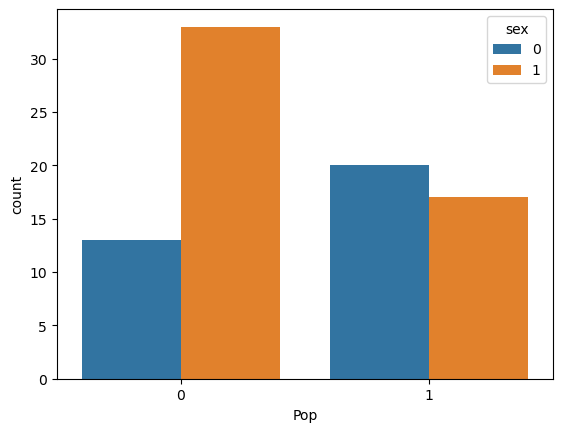

In [9]:
sns.countplot(data = df,
              x = 'Pop',
              hue = 'sex')

<AxesSubplot:xlabel='Pop', ylabel='count'>

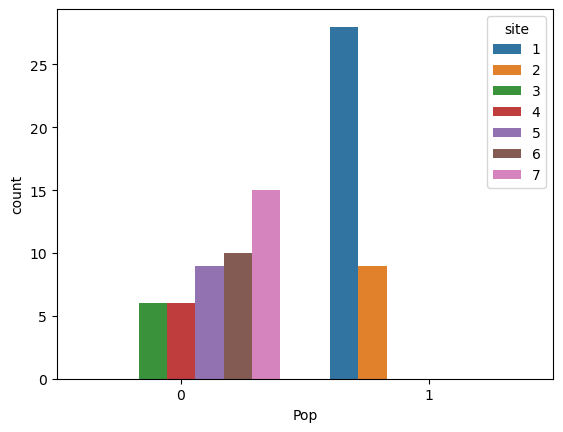

In [10]:
sns.countplot(data = df,
              x = 'Pop',
              hue = 'site')

### It's so easy to know where the possums come from just these captured areas.

* Let's Remove the site column for this classification :)

In [11]:
df = df.drop('site',axis  =1)

x_train,x_test,y_train,y_test = train_test_split(df.drop('Pop',axis = 1), df['Pop'], test_size = 0.7, stratify = df['Pop'],
                                                random_state = 42)

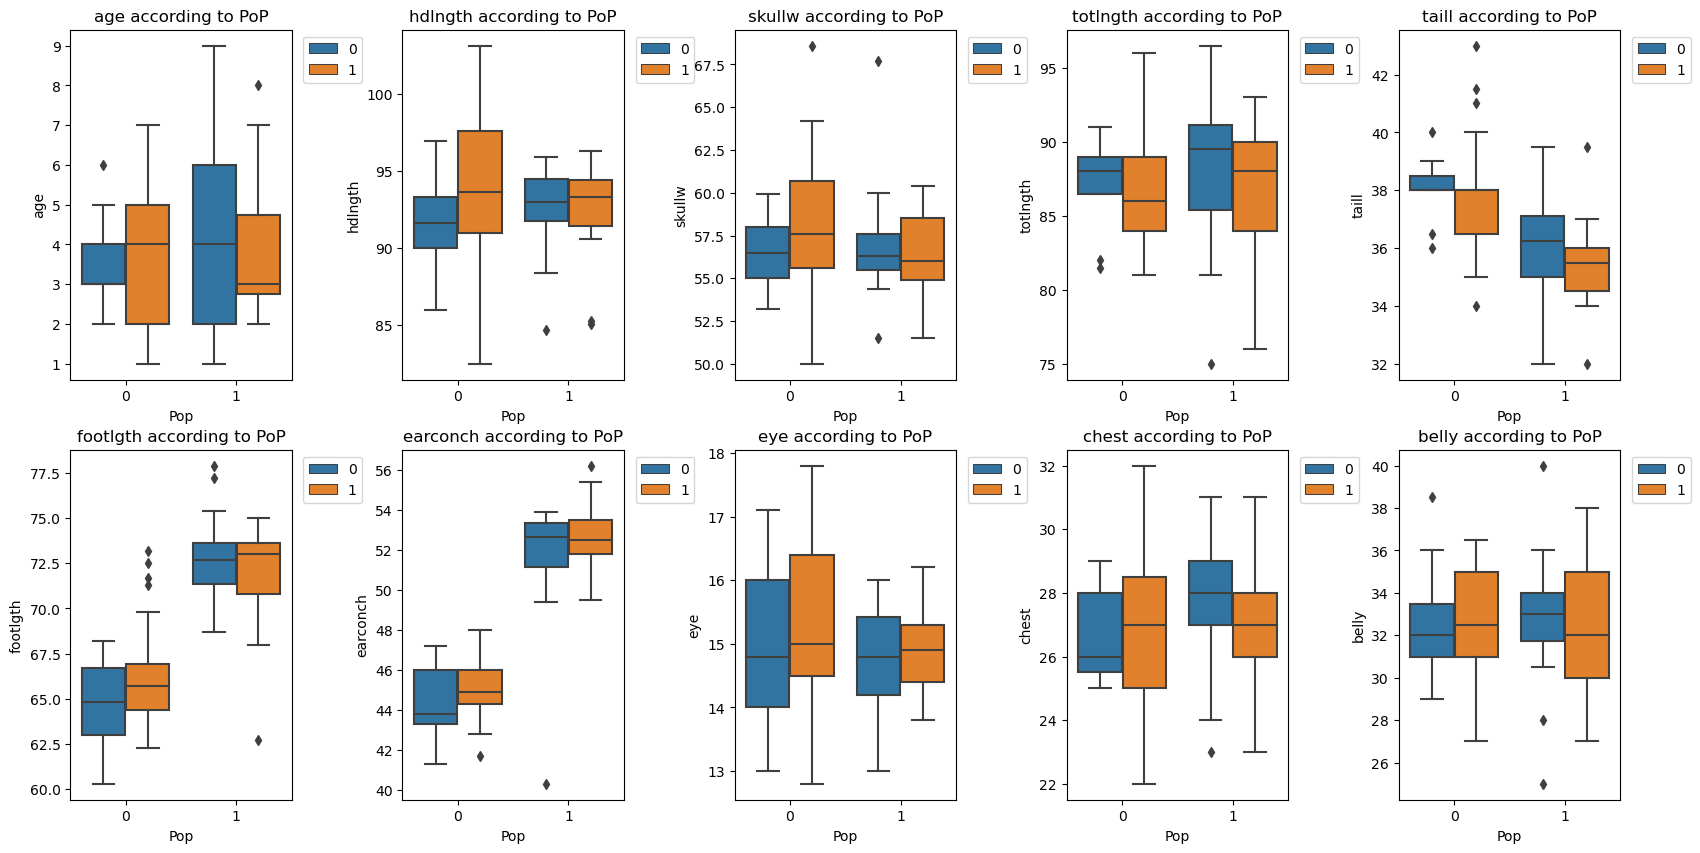

In [12]:
cols = ['age', 'hdlngth', 'skullw', 'totlngth', 'taill',
       'footlgth', 'earconch', 'eye', 'chest', 'belly']

fig,ax = plt.subplots(nrows = 2,ncols = 5,
                     figsize = (20,10))

plt.subplots_adjust(wspace = 0.5)

ax = ax.flatten()

for i,var in enumerate(cols):
    
    sns.boxplot(data = df,
                x = 'Pop',
                y = var,
                hue = 'sex',
                ax = ax[i])
    
    ax[i].set_title(f'{var} according to PoP')
    ax[i].legend(loc = 'upper right',
                 bbox_to_anchor = (1.35,1))

### Oh, i can see

* The possum from Victoria has relatively hot big feet and big ears
* The possum from another region has a relatively longer tail

In [13]:
params = {'n_estimators': 100,
          'objective': 'binary:logistic',
           'learning_rate': 0.1,
           'max_depth':3,
           'eval_metric': 'logloss'} 

fold = KFold(n_splits = 5, shuffle = True)

accuracy_list = []
f1_list = []

for i,(train_idx,valid_idx) in enumerate(fold.split(x_train,y_train)):
    
    
    train_x,train_y = x_train.iloc[train_idx],y_train.iloc[train_idx]
    valid_x,valid_y = x_train.iloc[valid_idx],y_train.iloc[valid_idx]
    
    clf = XGBClassifier(**params)
    
    clf.fit(train_x,train_y,
                  eval_set = [(train_x,train_y),(valid_x,valid_y)],
                  verbose = 0)
    
    acc_score = accuracy_score(valid_y, clf.predict(valid_x))
    f1_s = f1_score(valid_y, clf.predict(valid_x))
    
    accuracy_list.append(acc_score)
    f1_list.append(f1_s)
    
    print(f'Accuracy Score of {i} Model')
    print(acc_score)
    print(f'F1 Score of {i} Model')
    print(f1_s)

Accuracy Score of 0 Model
1.0
F1 Score of 0 Model
1.0
Accuracy Score of 1 Model
1.0
F1 Score of 1 Model
1.0
Accuracy Score of 2 Model
1.0
F1 Score of 2 Model
1.0
Accuracy Score of 3 Model
1.0
F1 Score of 3 Model
1.0
Accuracy Score of 4 Model
1.0
F1 Score of 4 Model
1.0


Text(0, 0.5, 'Log Loss')

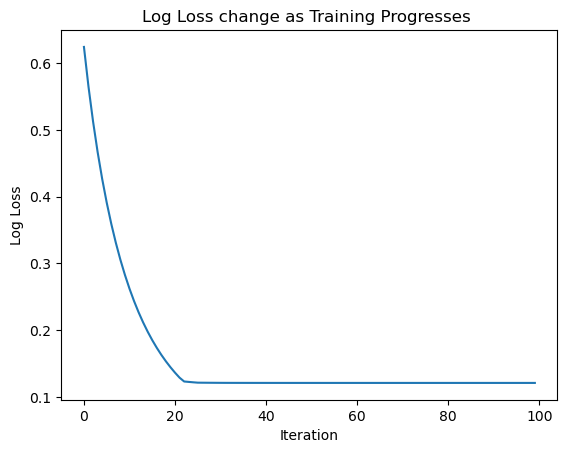

In [14]:
loss = clf.evals_result_['validation_0']['logloss']

iteration = range(len(loss))

plt.plot(iteration,loss)
plt.title('Log Loss change as Training Progresses ')
plt.xlabel('Iteration')
plt.ylabel('Log Loss')

Text(0.5, 1.0, 'ROC Curve of XBGBoost')

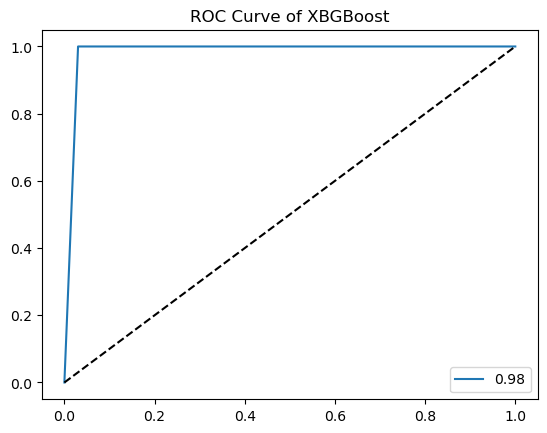

In [15]:
predicted = clf.predict(x_test)

fpr,tpr,_ = roc_curve(y_test,predicted)
AUC = round(auc(fpr,tpr),2)

plt.plot(fpr,tpr, label = AUC)
plt.plot([0,1],[0,1], 'k--')
plt.legend()

plt.title('ROC Curve of XBGBoost')

Text(0.5, 1.0, 'Confusion Matrix XBG Classifier')

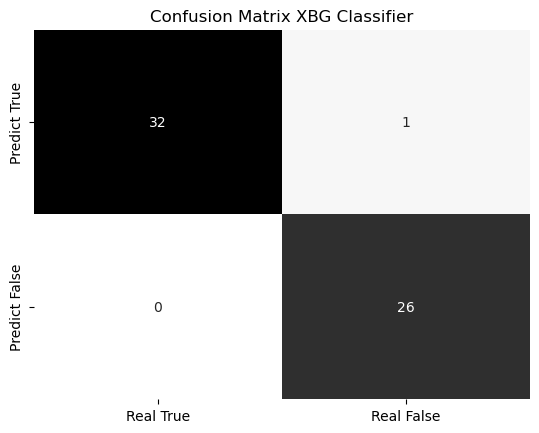

In [16]:
confusion_mt = pd.DataFrame(confusion_matrix(y_test,predicted), index = ['Predict True','Predict False'],
                                                 columns = ['Real True', 'Real False'])

sns.heatmap(confusion_mt, annot = True, cmap = 'binary',
            cbar = False)
plt.title('Confusion Matrix XBG Classifier')

# Whats your belly size , Possum 🐭
![](http://image.dongascience.com/Photo/2019/12/9d5a144256c8c856e3671fa2ac34fb88.jpg)

<AxesSubplot:>

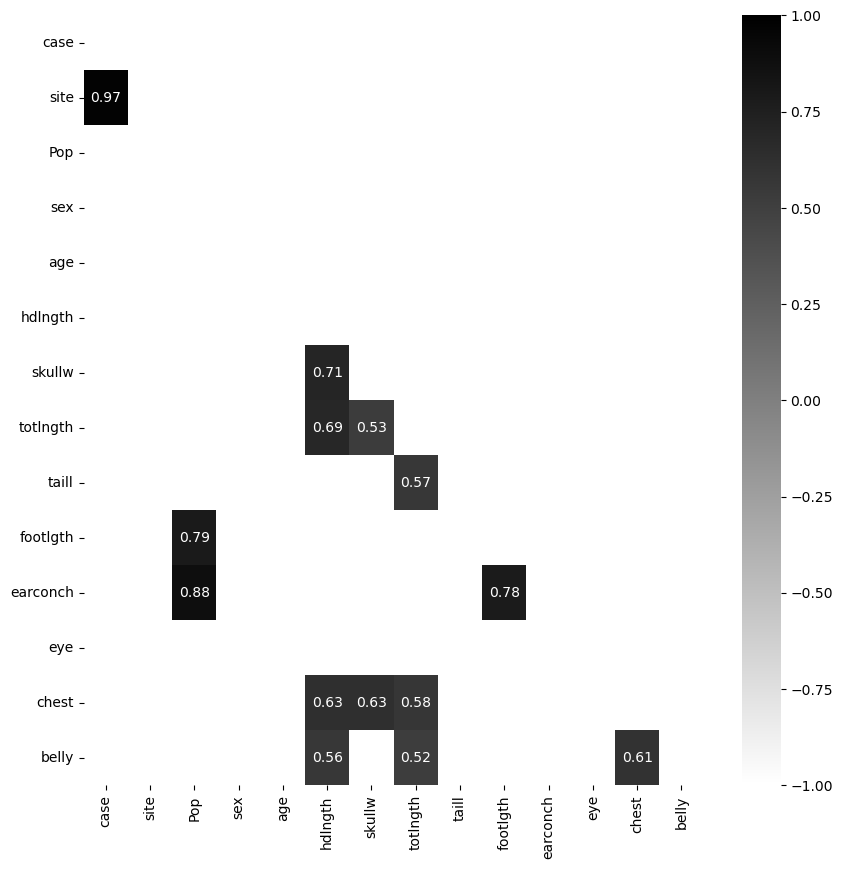

In [17]:
corr = data.corr()
mask = np.triu(np.ones_like(corr))

plt.figure(figsize = [10,10])
sns.heatmap(corr[corr > np.abs(0.5)], mask = mask, annot = True, cmap = 'binary', vmin = -1, vmax = 1)

In [18]:
x_train,x_test,y_train,y_test = train_test_split(data.drop('belly',axis = 1), data['belly'], test_size = 0.7, stratify = data['Pop'],
                                                random_state = 42)

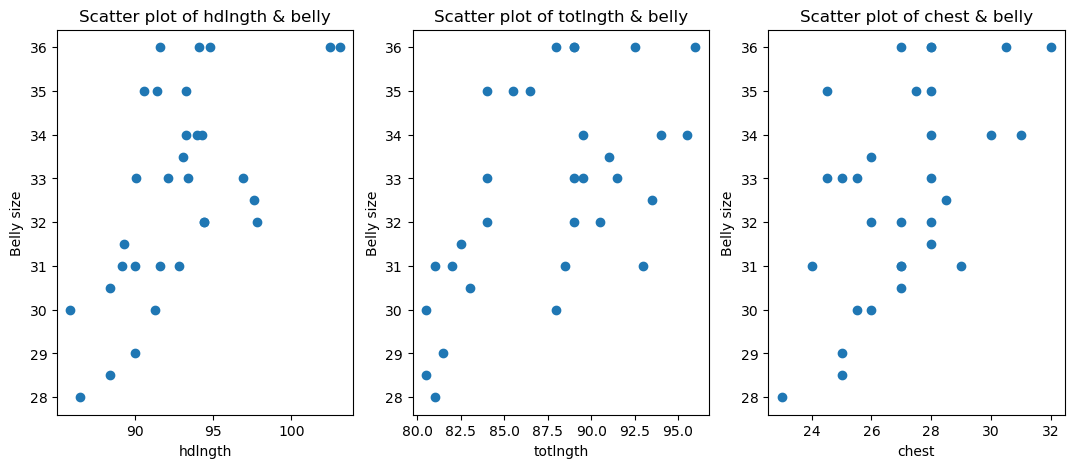

In [19]:
cols = ['hdlngth','totlngth','chest']

fig,ax = plt.subplots(ncols = 3, figsize = (13,5))

for i,var in enumerate(cols):
    
    ax[i].scatter(x_train[var], y_train)
    ax[i].set_title(f'Scatter plot of {var} & belly')
    ax[i].set_xlabel(var)
    ax[i].set_ylabel('Belly size')

In [20]:
params = {'n_estimators': 500,
          'objective': 'reg:squarederror',
           'learning_rate': 0.1,
           'max_depth':8,
           'eval_metric': 'mae'} 


for i,(train_idx,valid_idx) in enumerate(fold.split(x_train,y_train)):
    
    
    train_x,train_y = x_train.iloc[train_idx],y_train.iloc[train_idx]
    valid_x,valid_y = x_train.iloc[valid_idx],y_train.iloc[valid_idx]
    
    reg = XGBRegressor(**params)
    
    reg.fit(train_x,train_y,
                  eval_set = [(train_x,train_y),(valid_x,valid_y)],
                  verbose = 0)
    
    mae = mean_absolute_error(valid_y, reg.predict(valid_x))
    
    print(f'MAE Score of model{i}:',mae)


MAE Score of model0: 1.8169452122279577
MAE Score of model1: 2.1393136978149414
MAE Score of model2: 2.0800603230794272
MAE Score of model3: 1.7944844563802083
MAE Score of model4: 1.7075846989949544


Text(0.5, 1.0, 'MAE Loss as Traing Proegresses')

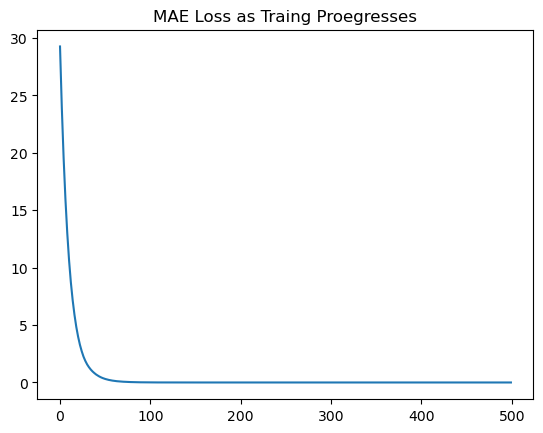

In [21]:
rmse = reg.evals_result_['validation_0']['mae']

iteration = range(len(rmse))

plt.plot(iteration,rmse)
plt.title('MAE Loss as Traing Proegresses')

In [22]:
predicted = reg.predict(x_test)

print('MAE Score : ', mean_absolute_error(y_test,predicted))

MAE Score :  2.3367195913236434
